# Entropy, conditional entropy, and mutual information

Overview:
* In this tutorial, we will learn how to describe the information that is shared between two variables (mutual information). In other words, how much uncertainty reduction is there to be had about variable 1 by measuring variable 2? 

* These concepts were initially developed in communication theory to describe the efficacy of transmitting signals over a noisy medium (like a noisy telephone line). For example, suppose that we want to know how good a communication channel is, or its effeciency in reliably relaying a message from point A (a 'sender') to point B (a 'reciever').

* Basically this is just like asking, "we know how good the signal is at A, and we recieved the message at B - how much information about A is still in the received signal B?". 

* So that is the general gist of it, but right away you can see the potential applicability of this metric in many fields of neuroscience, psychology, engeneering, etc. In neuroscience, we're bascially dealing with a series of communication channels that are corrupted by noise (i.e. synapses). It is therefore reasonable to ask: how much information from neuron A effectively propogates to neuron B? (or conversely, how much  information is lost?).

* However, this logic works for any combination of variables: two continuous variables, two discrete variables, one continuous and one discrete, etc. As a result, we can ask questions about any two variables really: how much information about median home  price is reflected in stock market fluctuations? etc.

* A few notes before we get started. First, we're going to be talking a lot about 'uncertainty' and 'uncertainty reduction'. While this is basically complementary to talking about certainty and an increase in certainty, we'll deal with the former terminology as it is embedded in some of the concepts that we'll discuss. 

* Second, we'll be dealing with variability in data, and how we can either attribute that variability in the data to 'noise' or to 'signals'. I.e. is the variability in one variable random wrt another variable? or does the variability in one variable systematically change with the variability in another? 

* In addition, MI has has a very intuitive interpretation in terms of the amount of information that is shared between two variables, and we'll get to that in a few minutes. 

<div class="alert alert-info">
Finally, a lot of people think at this point, "why not just correlate the variables using a normal r-value?". There are a few answers to this, but the simplest is this: correlation assumes a linear relationship (or, in more complex forms, a known relationship or you have to assume a relationship) between variables. Mutual information does not, and can generally capture any form of linear or non-linear relationship between two variables. This makes it a very powerful and general purpose metric.
</div>

[jackknife correction](https://www.pnas.org/content/115/40/9956)

<div class="alert alert-warning">
From the above linked paper from Zeng, Xia, and Tong (their Abstract): Quantifying the dependence between two random variables is a fundamental issue in data analysis, and thus many measures have been proposed. Recent studies have focused on the renowned mutual information (MI) [Reshef DN, et al. (2011) Science 334:1518–1524]. However, “Unfortunately, reliably estimating mutual information from finite continuous data remains a significant and unresolved problem” [Kinney JB, Atwal GS (2014) Proc Natl Acad Sci USA 111:3354–3359]. In this paper, we examine the kernel estimation of MI and show that the bandwidths involved should be equalized. We consider a jackknife version of the kernel estimate with equalized bandwidth and allow the bandwidth to vary over an interval. We estimate the MI by the largest value among these kernel estimates and establish the associated theoretical underpinnings.
</div>

* This is a very important concept to deal with - MI, esp for continuous variables, is highly unstable and requires correction procedures to counter the bias that is inherent in estimating MI for small data sets. 
* So while at the start of the tutorial we'll use discrete arrays of numbers that have few unique entries to demonstrate the basic concepts (like binary weighted coin flips, for example), things will get a bit crazier when we move on to continuous arrays of values. 
* Note also that the proposed jacknife correction from this PNAS paper is just one approach...I'm implementing it because in the few cases I've tried, it seems to be pretty numerically stable. Hwoever, there are other slightly more straightforward approaches that build on the ideas that we discussed in the "randomization" tutorial a few weeks back (and indeed,the jacknife approach is logically related as well).  

## Imports

In [89]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi
import matplotlib.pyplot as plt

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

PART II: Entropy as a measure of variability

* Shannon Entropy is related to the variability of data, but is more specifically defined as the average uncertainty in a set of measurements 
* Consider coin tosses - lets say we have a balanced coin, and we flip it once. We can represent the outcome of a single toss as a 0 or a 1 (a head or a tail), and this has an entropy (uncertainty) of 1 bit. In other words, we would reduce our uncertainty completely after we observed the outcome, and that would correspond to a reduction of 1 bit. 
    * By extension, if we flipped the coin twice, then the entropy would be 2 bits (00, 01, 10, or 11) because we would reduce our uncertainty by 2 bits after we observed the outcome. 

* To keep with the coin analogy...when the coin is balanced and heads and tails are equally likely, then the entropy is highest because uncertainty is maximized and flipping the coin will give you 1 bit of information.  
* To see why entropy is maximized in this situation, consider a biased coin  that comes up heads 60% the time. 
    * In this case, we could predict the outcome of the coin flip better than chance simply by going with our prior of 'heads'. Thus, the entropy assoicated with a biased coin is less than the entropy associated with the unbiased coin, because the reduction in uncertainty is lower with the biased coin than with the unbaised coin. 
    * Put simply, we learn less after flipping the biased coin than we do when we flip the unbiased coin!  
* This example brings up an important point: entropy as a measure of uncertainty is maximized when all possible outcomes are equally likely because you have no prior info upon which to make an educated guess about the outcome (i.e. a uniform distribution on the span of possible outcomes has the highest entropy). 
    * Therefore, in the case of a uniform distribution, making a measurement will maximally reduce your uncertainty, as you have no prior knowledge upon which to base a guess about the outcome in advance. 
    * In contrast, when only a subset of all possible outcomes are possible, then entropy is lower as the information gain from making a measurement is not much beyond your priors (what you already knew).

## To figure out the entropy of a measurement in terms of bits (the most common metric), we can use the log2 function, referred to as the binary logarithm and the inverse function of 2^N. The log2(n) is the power to which the number 2 must be raised to obtain the value n. Lets go back to our coin flip example with a fair coin. Suppose you flipped the coin once - the entropy would be 1 because there are two possible outcomes.

In [4]:
np.log2(2) # log2(n) or 2^x = n? ...x = 1

1.0

##  If you flipped the coin twice you'd have 4 possible outcomes (00,10,01,11), or three times you'd have 8 possible outcomes:

In [7]:
print(np.log2(4)) # or 2^x = n, x = 2
print(np.log2(8)) # or 2^x = n, x = 3

2.0
3.0


## To see the general shape of the function, plot out log2(x:y) to see the relationship between the number of possible outcomes and the entropy in bits

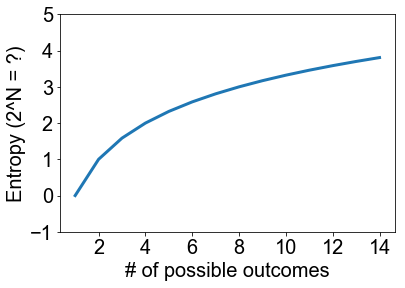

In [21]:
# why am i going from 1,15 instead of our usual 0 based counting?
plt.plot(np.arange(1,15), np.log2(np.arange(1,15)), linewidth=3)
plt.ylim([-1,5])
plt.xticks(**fig_font)
plt.yticks(**fig_font)
plt.ylabel('Entropy (2^N = ?)', **fig_font)
plt.xlabel('# of possible outcomes', **fig_font)
plt.show()
# note that log2(0) == -inf, and that log2(1)==0

## Going back to the above notion that entropy is maximial when the outcome is completely uncertain (e.g. a fair coin), then we can start to develop an intuition about expressing entropy in terms of the probability that some event will occur, denoted P(X). 
* Lets take a more complex case - lets say that we have a slot machine that has two wheels on it and the first wheel can take one of N states and the second can take one of M states  when we pull the handle. Considering just the first wheel, the possible outcomes are {x1....xn}, and if each outcome is equally likely, then p(xi)= 1/n.  So, for example, if n = 16, then the total entropy of wheel 1 can be represented  by 4 bits of information(four binary numbers). 

In [23]:
np.log2(16)

4.0

## Now what about the second wheel? It can take on M states. So inutively the total number of possible outcomes for both wheels is N * M. The uncertainty of the outcome in this case is then:

In [22]:
n = 16;
m = 16;
np.log2(n*m)

# which recall is equal to 
np.log2(n) + np.log2(m) 

8.0

## Which gives us a nice way to account for the probability of outcomes across multiple variables via summation! Why is this computationally convienent, esp on digital computers?

## So in this case we need 8 bits of information to specify all possible outcomes. Now lets consider each possible outcome in isolation. what is the uncertainty associated with each event? its the probability of that event occuring, which is p(xi) = 1/n. So in terms of bits, we have :

In [26]:
n = 16;
-np.log2(1/n)  #why negative when dealing with probabilities? log2(1)-log2(n)

4.0

## What we'd like though is a way to assess the average uncertainty of a particular outcome across all possible outcomes. How would you do that? 
* Intuitively, you'd take the uncertainty of each outcome (-log2(p(xi)) and weight it by the probabiltiy that the event will actually  occur, like this (where entropy is denoted, by convention, as H):

In [31]:
# H = -sum_over_all_i( p(xi) * log2(p(xi)) )
n = 16;
H = 0;
for i in np.arange(n):
    H = H + -( (1/n) * np.log2(1/n) )

print(H)

4.0


## What does H, the average uncertaintly, equal when all events are equally likely? it equals the uncertaintly of each event, which it should. And note that this framework would let you compute the average uncertainty (entropy) across both slot machine wheels by just adding the entropies:

In [22]:
n = 16 # number of possible outcomes for machine 1
m = 16 # number of possible outcomes for machine 2
H = 0
for i in np.arange(n):
    H = H + -( (1/n) * np.log2(1/n) )

for i in np.arange(m):
    H = H + -( (1/m) * np.log2(1/m) )

print(H)  

8.0


3.4070302496


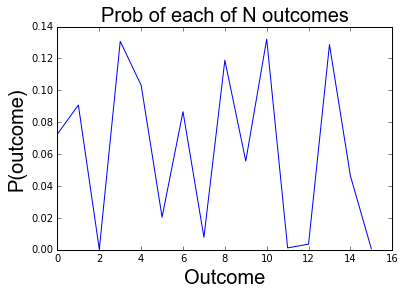

In [90]:
# what about when all events are not equally likely, which is the more
# interesting case to consider.
# Remember that with 16 possible equally likely outcomes
# we should have an entropy of 4
n = 16
px = np.random.rand(n)
px /= np.sum(px) # convert the random numbers to probabilities

H = 0
for i in np.arange(n):
    H = H + -( px[i] * np.log2(px[i]) )

print(H)

plt.plot(np.arange(n),px)
plt.xlabel('Outcome', **fig_font)
plt.ylabel('P(outcome)', **fig_font)
plt.title('Prob of each of N outcomes', **fig_font)
plt.show()

<div class="alert alert-info">
Note that the entropy is lower because we've moved away from the point where everything is maximally unpredictable (i.e. a uniform distribution). This demonstrates a principle that relates probability distributions to entropy: uniform probability distributions have maximum entropy, and non-uniform distributions will generally have less entropy because some outcomes are more likely than others so you learn less by making a measurement.
</div>

SUMMARY
* Entropy is a measure of uncertainty, and as uncertainty goes up (and is maximized when all outcomes are equally likely) then the information gained by making a measurement goes up. 
* So if you know the oucome in advance (e.g. a coin with two heads) then p(tails) = 0 and there is no uncertainty, entropy is 0, and there is no reduction in uncertainty to be gained by flipping the coin at all. 
* If you have a fair coin, then p(head)==p(tail) and entropy will be maximum and you will maximally reduce your uncertainty by making the measurement (in this case, you will fully disambiguate the outcome, gaining 1 bit of information where the total uncertainty is 1 bit). 

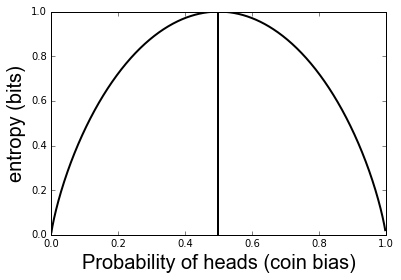

In [91]:
# number of outcomes (e.g. heads or tails)
n = 2  

# vary the probability of heads
ph = np.arange(.001,.999,.001)  

# alloc to store entropy at each probability
H = np.zeros(len(ph))

for j in np.arange(len(ph)):
    px[0] = ph[j]    # p(heads)
    px[1] = 1-px[0]  # p(tails))
    
    # then compute entropy
    for i in np.arange(n):
        H[j] = H[j] + -( px[i] * np.log2(px[i]) );
    

plt.plot(ph, H, 'k', linewidth=2)
plt.xlabel('Probability of heads (coin bias)', **fig_font)
plt.ylabel('entropy (bits)', **fig_font)
plt.axvline(.5, color='k', linewidth=2)
plt.show()
# entropy is maximized with maximum uncertainty and will max out at
# log2(n)

PART III: Mutual information (MI). 

* MI is a measure of how much knowing  about 1 variable tells you about the state of another variable. Putting aside entropy and measures of uncertainty/variance for a minute, here is the  intuition. 
    * Suppose you have two variables that are completely unrelated to each other: measuring one variable will tell you nothing about the state of the other variable. 
    * In contrast, if you have two variables that are perfectly correlated, then measuring one variable will tell you everything about the state of the other. 
    * In this special (unusual) case, the mutual information will be equal to the entropy of either variable alone (that is: the information gained by measuring one variable will be equal to the information gained by measuring both)
 
To put this back in terms of entropy: lets say we have two variables, X and Y. If we want to assess the MI between X and Y, then the intuition is that we need to know the following difference score:

(total entropy of X) -  (entropy of X given that we know Y). 

In other words, how much is uncertainty about X REDUCED when we measure Y? That is the MI between the two variables. And it leads to the definition of MI:

MI = H(X) - H(X|Y)  

where H(X) is the entropy of X, and H(X|Y) is the conditional entropy of X given that we've measured Y - it the average entropy of X across all values of Y

Going back to our examples above - suppose X and Y are unrelated (independent) and measuring Y doesn't tell you anything about X, so: 

H(X) == H(X|Y), so MI = H(X) - H(X) = 0

On the other hand, if the two variables are perfectly related, then knowing Y will not give us any reduction in uncertainty about X, so:

H(X|Y) = 0, and MI = H(X) - 0, or MI = H(X)

Lets do a few examples - first generate two sequences that are randomly generated independly from each other
We'll start with discrete values (as opposed to continuous values, which is a little trickier)

In [171]:
# two discrete, uncorrelated arrays filled with 0's and 1's

N = 1000   # number of data points
x = np.round(np.random.rand(N))
y = np.round(np.random.rand(N))

px = np.zeros(2)
px[0] = np.sum(x)/N   # probability that x==1
px[1] = 1-px[0];      # prob that x==0

# do in one line instead of looping using the * operator
Hx = -sum( px * np.log2(px) )

# then compute average conditional entropy of x given y (Hxy).
# 1) Compute the entropy of X given each possible value of Y
# 2) Multiply H(X|Yi) with the probability of each Y (i.e. p(yi))
# 3) Sum H(X|Yi) over all i

# initialize Hxy
Hxy=0

# figure out the unique values in each vector (we know that its 0/1, but do this just for good practice)
uniquex = np.unique(x)
uniquey = np.unique(y)

# loop over unique elements of y, in this case 0,1
for i in np.arange(len(uniquey)): 
    
    # probability that y==y(i) (prob of each y)
    py = np.sum(y==uniquey[i]) / N

    # then loop over all possible x's to compute entropy of x at each y
    tmp=0
    for j in np.arange(len(uniquex)):
        px_y = np.sum((x==uniquex[j]) & (y==uniquey[i])) / np.sum(y==uniquey[i])    # e.g. prob x==1 when y==0
        tmp += (-( px_y * np.log2(px_y) ))                                                 # entropy      
        
    # then tally up entropy of x given each specific y multiplied by the probability of that y (py)
    Hxy += py*tmp

# then we have everything we need to compute MI, which in this case should
# be ~0 becuase the variables are completely independent!
MI = Hx - Hxy
print(MI)

0.000277811661881


## Now that we've walked all the way through one example, lets define a few functions to make things easier

In [172]:
def entropy(x):
    """compute entropy of discrete array x

    Args:
        x (int): array of discrete values

    Returns:
        Hx (float): entropy of x

    """
    # figure out unique values of x - can be more than just 0s, 1s
    uniquex = np.unique(x)

    Hx = 0
    for i in np.arange(len(uniquex)):
        # probability that x==uniquex[i]
        px = np.sum(x==uniquex[i])/len(x)    

        # check for px==0 because log2(0) = -inf
        if px!=0:
            Hx += (-np.sum( px * np.log2(px) ))  
        else:
            print('px is zero for value ', i)
        
    return Hx

In [173]:
def condEntropy(x,y):
    
    """
    conditional entropy, or the average entropy of x given each y, or Hxy
    1) For all Y {i=1:numel(X)}, compute the entropy of X given each Y
    2) Multiply H(X|Y==i) with the probability of each Y (i.e. pxi)
    3) Sum over all i

    Args:
        x (int): array of discrete values
        y (int): array of discrete values
        
    Returns:
        Hxy (float): average conditional entropy of x given y

    """

    Hxy=0
    uniquex = np.unique(x)
    uniquey = np.unique(y)

    # loop over unique elements of y
    for i in np.arange(len(uniquey)): 

        # probability that y==y(i) (prob of each y)
        py = np.sum(y==uniquey[i]) / N

        # then loop over all possible x's to compute entropy of x at each y
        tmp=0
        for j in np.arange(len(uniquex)):
            px_y = np.sum((x==uniquex[j]) & (y==uniquey[i])) / np.sum(y==uniquey[i])    # e.g. prob x==1 when y==0
            tmp += (-( px_y * np.log2(px_y) ))                                     # entropy      

        # then tally up entropy of x given each specific y multiplied by the probability of that y (py)
        Hxy += py*tmp

    return Hxy

## Lets give the functions a try

In [179]:
N = 1000   # number of data points
x = np.round(np.random.rand(N))
y = np.round(np.random.rand(N))
Hx = entropy(x=x)
Hxy = condEntropy(x=x,y=y)
print('MI is: ', Hx-Hxy)

MI is:  0.000661891292784


## Now lets try a more complicated (and useful) example where we have one discrete variable and one continuous variable
* This often comes up in experiments where you have a set of discrete stimuli and then a continuous output measure (e.g. LFP power, spike rate over a time window, etc)
* Logic here is the same as the case for two discrete variables, but generating the PDF for the continuous variable is trickier and there are many (many many) ways of doing it. 
    * For comparison, with our coin tosses, you can get the PDF by sum(heads)/total_tosses...
    * But for a continuous metric where you have all unique values, this doesn't work (i.e. if each value happens once and only once then how do you compute the likelihood of observing that value?
    * To solve this problem, we need to generate an estimate of the data generating PDF based on our samples of the continuous data
    * Common approaches are to build histograms of the data to approximate the PDF, or to use an approach like Kernel Density Estimation to approximate the PDF 
* We'll start with the KDE implementation in sklearn 
    
[histograms vs KDE - good read!](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)

[And a TMI read for muliple KDE implementations](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/)

## Import KDE functionality from sklearn

In [180]:
from sklearn.neighbors import KernelDensity

## Set up our variables - one discrete and one continuous
* lets assume that our data came from an experiment where we show 4 different stimuli (e.g. motion directions) and then record spike rate as a continuous metric (e.g. spike rate smoothed with a 5ms Gaussian window). 

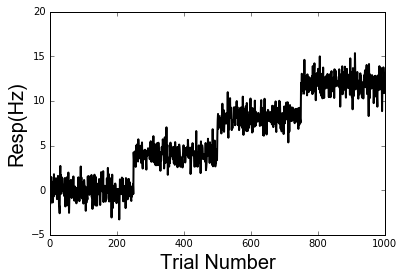

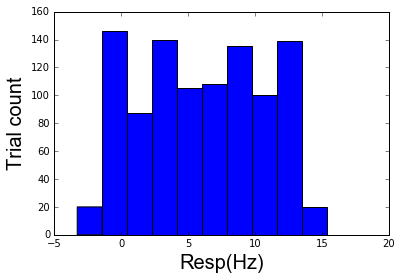

In [285]:
# number of trials in our experiment
N = 1000

# Generate a list of stims
num_stims = 4
stims = np.repeat(np.arange(4), N/num_stims) # div by num_stims to keep output length constant

# Now generate our list of continuous spike rates in response to each stimulus
# Set it up so that there is a differential response to each of the 4 stims (i.e. MI>0)
scale_factor = 4 # how much response to each stim differs
resp=[]
for i in np.arange(num_stims):
    resp = np.hstack((resp, np.random.randn(int(N/num_stims))+(i*scale_factor)))
    
plt.plot(np.arange(N), resp, 'k', linewidth=2)
plt.xlabel('Trial Number', **fig_font)
plt.ylabel('Resp(Hz)', **fig_font)
plt.show()

# also show as a histogram to get a feel for the distribution
num_bins = 10 # change this! you'll get a feel for why using histograms for estimating PDFs is tricky
plt.hist(resp, bins=num_bins)
plt.xlabel('Resp(Hz)', **fig_font)
plt.ylabel('Trial count', **fig_font)
plt.show()

## Now use our function to compute the entropy of the discrete variable (the stimulus type)

In [270]:
# should be 2 because 4 possibilities that are equally likely
Hx = entropy(x=stims)
print(Hx)

2.0


## Now use sklearn KDE algorithm to estimate a PDF of our continuous response

In [286]:
# first define a set of points over which to evaluate the PDF

# figure out min and max of our data - good start for picking a range (use ceil and floor...)
min_resp = np.floor(np.min(resp))
max_resp = np.ceil(np.max(resp))

# then define the number of points that we want to eval the function over
# I'll choose N/4 here - we can play with it later.
num_points = int(N/4)

# then define the x_range
x_range = np.linspace(min_resp, max_resp, num_points)

# KDE function expects a 2d array, so expand x to have a singular second dim
if len(x_range.shape):
    x_range = x_range[:, np.newaxis]
    
print(x_range.shape)

(250, 1)


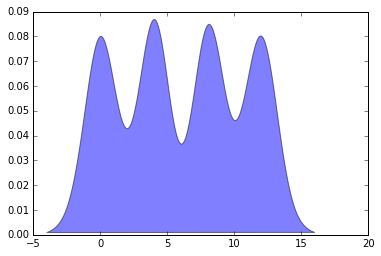

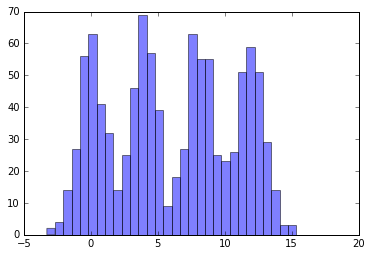

In [300]:
# then lets call our KDE function and we'll just pick an arbitrary bandwidth for the kernel
bandwidth = 0.2

# make our data a N,1 matrix for input to KDE function
if len(resp.shape)==1:
    resp = resp[:,np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(resp)
log_dens = kde.score_samples(x_range)


plt.fill(x_range[:, 0], np.exp(log_dens), alpha=0.5)
plt.show()

num_bins=30
plt.hist(resp, bins = num_bins, alpha=0.5)
plt.show()

In [ ]:
kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
kde_skl.fit(x[:, np.newaxis])
# score_samples() returns the log-likelihood of the samples
log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
return np.exp(log_pdf)

In [ ]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')
ax.set_xlim(-4.5, 3.5);

In [ ]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print grid.best_params_

In [4]:
n_bins = 30
def calc_MI(X,Y,bins = np.linspace(-90,90,n_bins+1)):
    bad = np.isnan(X) | np.isnan(Y)
    X = X[~bad]
    Y = Y[~bad]
    
    c_XY = np.histogram2d(X,Y,bins)[0]
    c_X = np.histogram(X,bins)[0]
    c_Y = np.histogram(Y,bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)
    
    MI = H_X + H_Y - H_XY
    return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

def calc_MI_ds(X,Y,n_samp=2000,n_iter=30,do_shuf=False,ret_all = False):
    MIs = []
    bad = np.isnan(X) | np.isnan(Y)
    X = X[~bad]
    Y = Y[~bad]
    
    for i in range(n_iter):
        if do_shuf:
            np.random.shuffle(X)
        samp = np.random.choice(len(X),n_samp,replace=False)
        MIs.append(calc_MI(X[samp],Y[samp]))
    if ret_all:
        return MIs
    return (np.mean(MIs), np.std(MIs))

In [18]:
x = np.random.rand(1000)*60
y = np.random.rand(1000)*60
n_bins = 600

mi = calc_MI(X=x,Y=y,bins = np.linspace(-90,90,n_bins+1))
print(mi)

5.07719825221
